In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Load Dataset

In [30]:
dataset = pd.read_csv('data\weather_dataset.csv', index_col='date', parse_dates=True)

In [31]:
dataset.head()

,Ttb,Tx,Tn,R,Utb,Un
date,,,,,,
2015-01-01,14.7,25.3,9.3,NaN,75.0,33.0
2015-01-02,13.9,23.5,7.5,NaN,75.8,37.0
2015-01-03,14.1,21.0,9.5,NaN,83.5,54.0
2015-01-04,16.5,18.8,14.6,NaN,88.3,83.0
2015-01-05,19.0,22.6,16.5,0.0,87.0,72.0


In [32]:
dataset.tail()

,Ttb,Tx,Tn,R,Utb,Un
date,,,,,,
2020-12-27,20.3,24.8,17.3,NaN,83.0,67.0
2020-12-28,20.7,23.6,18.8,NaN,88.0,77.0
2020-12-29,21.4,25.8,19.9,NaN,86.0,74.0
2020-12-30,17.5,20.9,16.2,NaN,50.0,42.0
2020-12-31,13.6,19.0,12.1,NaN,57.0,41.0


# Data Preprocessing & Visualizing

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ttb     2192 non-null   float64
 1   Tx      2192 non-null   float64
 2   Tn      2192 non-null   float64
 3   R       988 non-null    float64
 4   Utb     2192 non-null   float64
 5   Un      2192 non-null   float64
dtypes: float64(6)
memory usage: 119.9 KB


### Replace missing values

In [34]:
dataset.isna().sum()

Ttb       0
Tx        0
Tn        0
R      1204
Utb       0
Un        0
dtype: int64

In [35]:
dataset = dataset.fillna(0.0)

In [36]:
dataset.isna().sum()

Ttb    0
Tx     0
Tn     0
R      0
Utb    0
Un     0
dtype: int64

### Visualizing

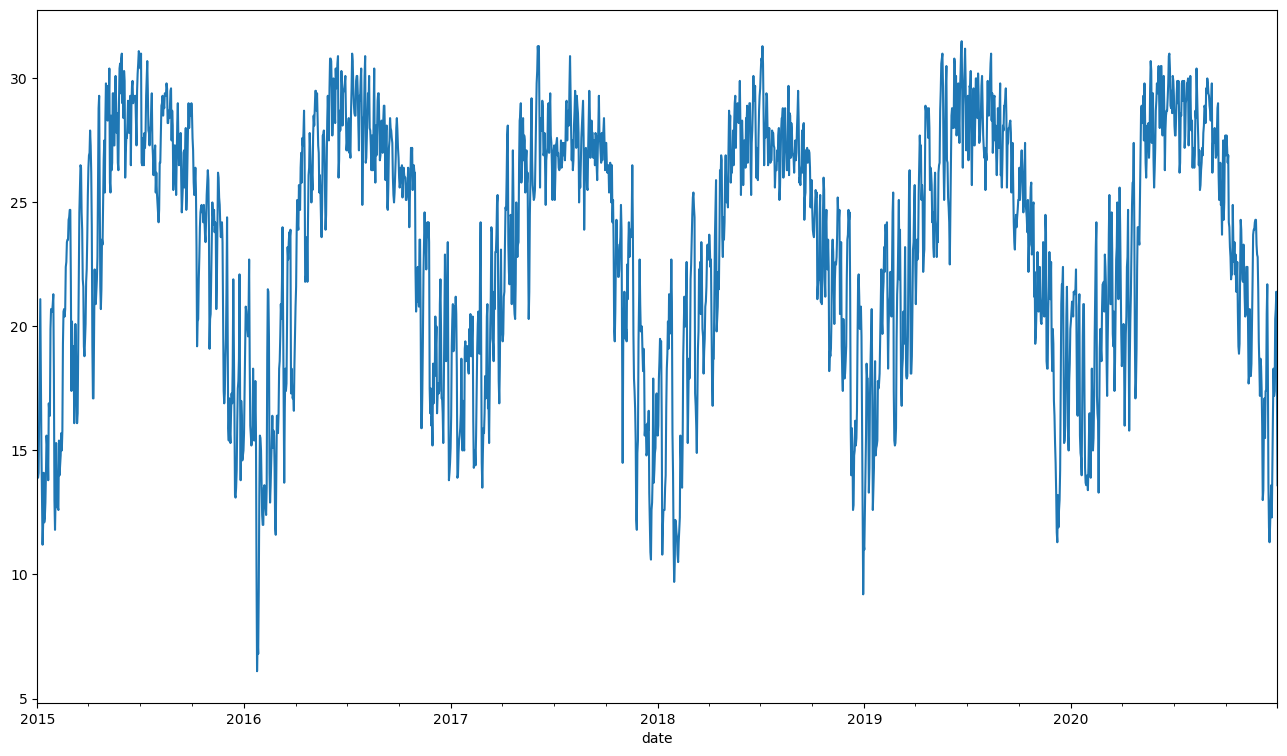

In [37]:
dataset['Ttb'].plot(figsize=(16,9));

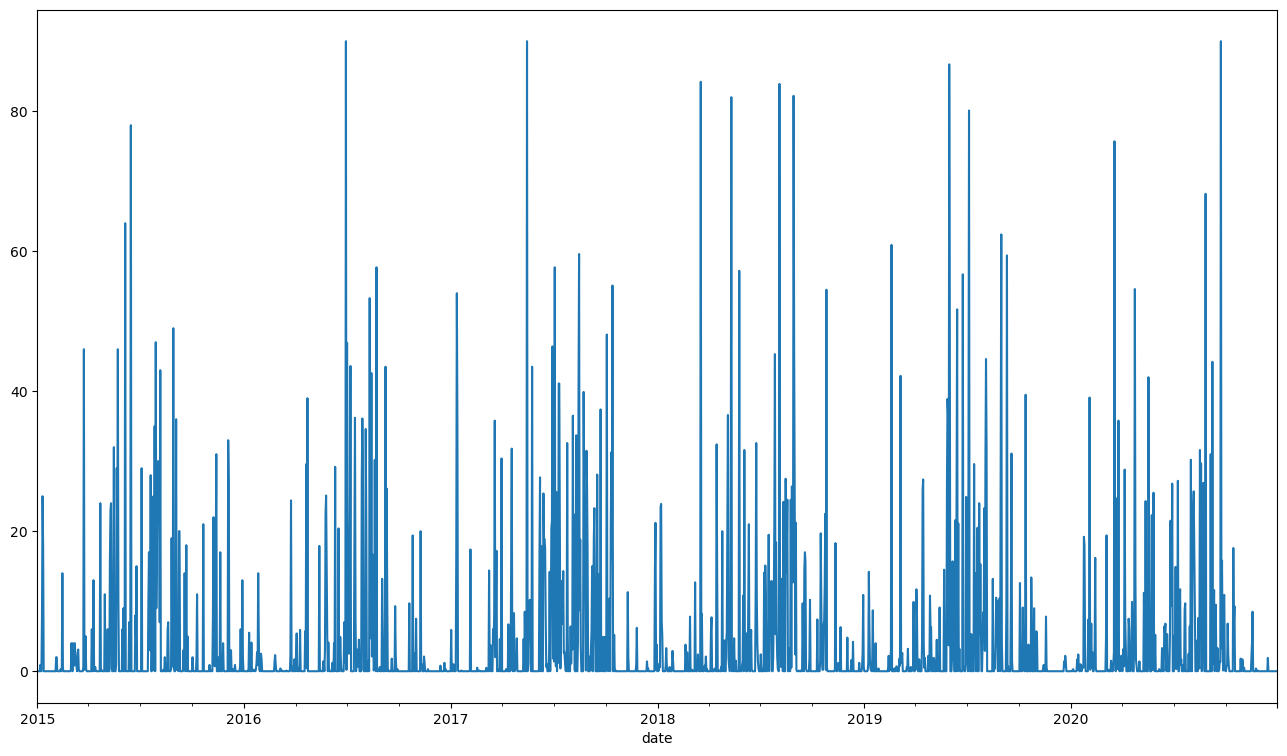

In [38]:
dataset['R'].plot(figsize=(16,9));


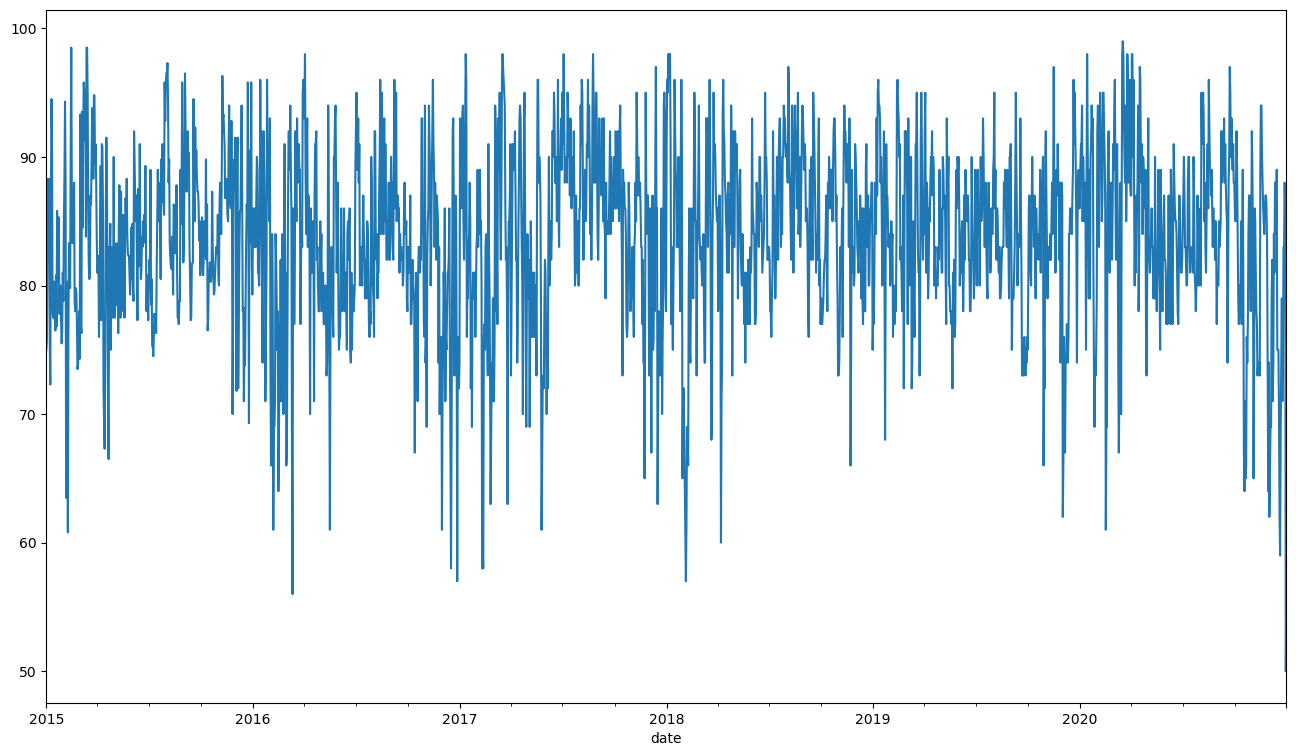

In [39]:
dataset['Utb'].plot(figsize=(16,9));

## `Phần nhiệt độ, lượng mưa, độ ẩm khá tuần hoàn => split data theo mùa chắc là giải quyết được, nếu không được thì phải dùng ARMA hay ARIMA gì đấy :3`

In [40]:
dataset.describe()

,Ttb,Tx,Tn,R,Utb,Un
count,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000,2192.000000
mean,23.350228,28.020073,20.466834,4.301369,83.805246,67.428832
std,5.042623,5.702109,4.949226,10.970441,6.906062,13.725397
min,6.100000,8.000000,2.500000,0.000000,50.000000,23.000000
25%,19.600000,24.000000,17.100000,0.000000,80.000000,59.000000
50%,24.500000,29.000000,21.600000,0.000000,84.000000,67.000000
75%,27.500000,32.800000,24.600000,2.000000,89.000000,77.000000
max,31.500000,39.000000,28.200000,90.000000,99.000000,98.000000


<AxesSubplot:>

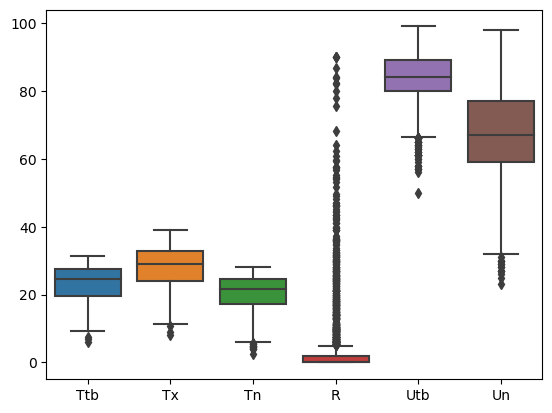

In [41]:
sns.boxplot(data=dataset)

## `Mấy cái chấm đen là ngoại lai. Khá là nhìu :(`

### Scaling dataset

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [43]:
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)

In [44]:
len(dataset_scaled)

2192

# Splitting Dataset

In [45]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [46]:

data_train = dataset_scaled[:2030].reshape((len(dataset[:2030]), len(dataset.columns)))
data_test = dataset_scaled[2000:].reshape((len(dataset[2000:]), len(dataset.columns)))

n_input = 30 # dựa vào 30 ngày trước để dự đoán ngày tiếp theo
generator_train = TimeseriesGenerator(data=data_train, targets=data_train, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(data=data_test, targets=data_test, length=n_input, batch_size=1)

print(len(generator_train), len(generator_test))
Xi, yi = generator_train[0]
#np.shape(Xi), np.shape(yi)
#generator_train[0]

2000 162


In [47]:
def split_data(data, rate=0.2):
    X, y = [], []
    
    for i in range(732, len(data)):
        X_i = np.array([data[i-732], data[i-731], data[i-730], data[i-729], data[i-728],
                    data[i-367], data[i-366], data[i-365], data[i-364], data[i-363],
                    data[i-2], data[i-1]])
        y_i = []
        y_i.append(data[i])
        
        X.append(X_i)
        y.append(y_i)
        
    pos_split = int((len(data) - 732)*(1 - rate))
    
    X = np.array(X)
    y = np.array(y)
    
    X_train, X_test, y_train, y_test = X[:pos_split], X[pos_split:], y[:pos_split], y[pos_split:]
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_data(data=dataset_scaled, rate=0.2)
print(X_test.shape, y_test.shape)
np.shape(X_test[0]), np.shape(y_test[0])

(292, 12, 6) (292, 1, 6)


((12, 6), (1, 6))

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [49]:
n_features = 6
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(12, n_features)))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18176     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 22,726
Trainable params: 22,726
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(x=X_train, y=y_train, epochs = 50, verbose =1)

Epoch 1/50
37/37 [==============================] - 3s 11ms/step - loss: 0.0470
Epoch 2/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0300
Epoch 3/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0295
Epoch 4/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0295
Epoch 5/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0296
Epoch 6/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0294
Epoch 7/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0292
Epoch 8/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0294
Epoch 9/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0293
Epoch 10/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0294
Epoch 11/50
37/37 [==============================] - 0s 11ms/step - loss: 0.0293
Epoch 12/50
37/37 [==============================] - 0s 12ms/step - loss: 0.0292
Epoch 13/50
37/37 [==================

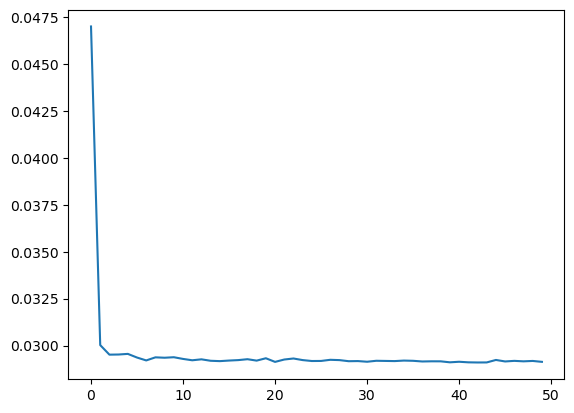

In [51]:
plt.plot(model.history.history['loss'])

# Test

In [52]:

y_predict = []

for i in range(len(X_test)):
    X_predict = np.array(X_test[i]).reshape((1, 12, 6))
    y_predict.append(model.predict(X_predict))

y_predict = np.array(y_predict)



1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 31ms/step


In [53]:
Ttb, Tx, Tn, R, Utb, Un = [], [], [], [], [], []
for element in y_predict:
    Ttb.append(element[0][0])
    Tx.append(element[0][1])
    Tn.append(element[0][2])
    R.append(element[0][3])
    Utb.append(element[0][4])
    Un.append(element[0][5])
    

# Evaluating

### Ttb (Mean Temperature)

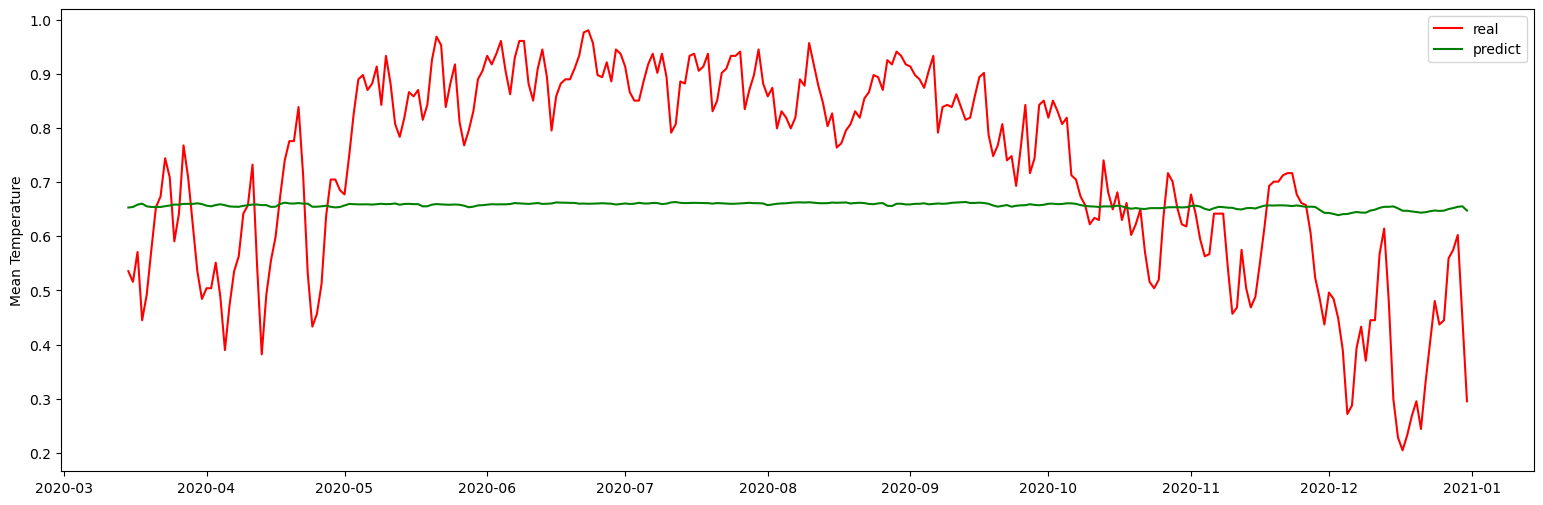

In [54]:
plt.figure(figsize=(19,6))
plt.plot(dataset[1900:].index, y_test[:,0,0], c='red', label='real')
plt.plot(dataset[1900:].index, Ttb, c='green', label='predict')
plt.legend()
plt.ylabel('Mean Temperature');

### Tx (Max Temperature)

In [55]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,1], c='red', label='real')
plt.plot(dataset[2030:].index, Tx, c='green', label='predict')
plt.legend()
plt.ylabel('Max Temperature');

NameError: name 'y_true' is not defined

<Figure size 1900x600 with 0 Axes>

### Tn (Min Temperature)

In [ ]:
plt.figure(figsize=(19,6))
plt.plot(dataset[1900:].index, y_test[:,0,2], c='red', label='real')
plt.plot(dataset[1900:].index, Tn, c='green', label='predict')
plt.legend()
plt.ylabel('Min Temperature');

### R (Rain)

In [ ]:
plt.figure(figsize=(19,6))
plt.plot(dataset[1900:].index, y_test[:,0,3], c='red', label='real')
plt.plot(dataset[1900:].index, R, c='green', label='predict')
plt.legend()
plt.ylabel('Rain');

### Utb (Mean Humidity)

In [ ]:
plt.figure(figsize=(19,6))
plt.plot(dataset[1900:].index, y_test[:,0,4], c='red', label='real')
plt.plot(dataset[1900:].index, Utb, c='green', label='predict')
plt.legend()
plt.ylabel('Mean Humidity');

### Un (Min Humidity)

In [ ]:
plt.figure(figsize=(19,6))
plt.plot(dataset[1900:].index, y_test[:,0,5], c='red', label='real')
plt.plot(dataset[1900:].index, Un, c='green', label='predict')
plt.legend()
plt.ylabel('Min Humidity');